In [1]:
# General libraries
# !pip install polyline networkx osmnx googlemaps pyarrow pandas

from shapely.geometry import shape
from shapely.geometry import LineString
import polyline
from osgeo import ogr, osr
import geopandas as gpd
import pandas as pd
import json
import time
from tqdm import tqdm


# Specific to osrm approach
import requests

# Specific to osmnx & networkx approach
import networkx as nx
import osmnx as ox

# Specific to googlemaps approach
import googlemaps

from folium import *

tqdm.pandas()

In [2]:
!pip install --upgrade pyarrow

In [3]:
# mount drive to access files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
samples = list(map(str,[67224, 66765, 54853, 28910, 67413, 11009, 46389, 80717, 35585, 65300, 54309, 72290, 83984, 9636, 1241, 67295, 30352, 78465, 39580, 11101, 74729, 49429, 83729, 27592, 49618, 45449, 1801, 46653, 38982, 16922, 53995, 20194, 36702, 57993, 48960, 52838, 7159, 36745, 8647, 28474, 57220, 63166, 10282, 38485, 50178, 20476, 37465, 4705, 63040, 35221, 15681, 79533, 74896, 29582, 60226, 23408, 25713, 33365, 83034, 11293, 52230, 28745, 37372, 69493, 32777, 24599, 41063, 12675, 66749, 10995, 10835, 79330, 72175, 43583, 45657, 51223, 76039, 74148, 56983, 57733, 23570, 41377, 46747, 57945, 57916, 31952, 16124, 51365, 8719, 2651, 36064, 9159, 19024, 14848, 72068, 71165, 29879, 67297, 12521, 32068, 25036, 51264, 65667, 43887, 42973, 53288, 45482, 75720, 83573, 43812, 79416, 51318, 17780, 46049, 20972, 81706, 34148, 67686, 71685, 34534, 20941, 82256, 82024, 53642, 5173, 44555, 22297, 47091, 64386, 81517, 6973, 46275, 13678, 44366, 29814, 76843, 39782, 81079, 38560, 52738, 48438, 77977, 43663, 45902, 9588, 9062, 33554, 79883, 50922, 72111, 83174, 14129, 30449, 51635, 4262, 27960, 15241, 15648, 76381, 1237, 62793, 33022, 42739, 47198, 3026, 14509, 14505, 18944, 32065, 83964, 16263, 30491, 32495, 58160, 24086, 51706, 49524, 64860, 82233, 52682, 77460, 57283, 9228, 29911, 1922, 20623, 79670, 27798, 54941, 27551, 32016, 24889, 73347, 46237, 23497, 47296, 8349, 22914, 21226, 25698, 60381, 52902, 7777, 12113, 48106, 11535, 70226, 16257, 66780, 28409, 56897, 73350, 40671, 50901, 76788, 65017, 8185, 68465, 76460, 70072, 7019, 19340, 3143, 6833, 3168, 47204, 10753, 24986, 25740, 41287, 34551, 57149, 46561, 60222, 72434, 64788, 56660, 51640, 41803, 16633, 80524, 38821, 14013, 62086, 71531, 56688, 44758, 73815, 57580, 17293, 79621, 82668, 1988, 81238, 25377, 46041, 13174, 11323, 76723, 83524, 51529, 24959, 63722, 18362, 73240, 16812, 35987, 68714, 18313, 76421, 32434, 31989, 14486, 39754, 47050, 46691, 30923, 6387, 58218, 22603, 32014, 3489, 74787, 17348, 16369, 14542, 52369, 22452, 58189, 39692, 49431, 51160, 80747, 21462, 20044, 13880, 58401, 15236, 25663, 32756, 68240, 37731, 19262, 26652, 32621, 29614, 82355, 82999, 47481, 15309, 1406, 40592, 12206, 13434, 79808, 35692, 38834, 67868, 10255, 40843, 82234, 25110, 68522, 34156, 38326, 22666, 16681, 52064, 51711, 74311, 29383, 13125, 71602, 61758, 4699, 5044, 79152, 52674, 27083, 12591, 47234, 31721, 6441, 52396, 56636, 71889, 53771, 51913, 56181, 39945, 83405, 80986, 13893, 61433, 65113, 54849, 76455, 73678, 81177, 38122, 56234, 19189, 25754, 9147, 39367, 27112, 17646, 15405, 46979, 21233, 16644, 24046, 50174, 2500, 56201, 15635, 15245, 73272, 11211, 39309, 18507, 57947, 1861, 48771, 80366, 66860, 24001, 48999, 83696, 83485, 41876, 38799, 78307, 5618, 8015, 71015, 4416, 61107, 17953, 65442, 46030, 62873, 43198, 21460, 82490, 73748, 12208, 55194, 12916, 80427, 12697, 43632, 1373, 83469, 7869, 48444, 74252, 1359, 21838, 63430, 73316, 8120, 81407, 50621, 73676, 23484, 81917, 57535, 48937, 67744, 58545, 2764, 57768, 72117, 74253, 48504, 43989, 43747, 78034, 16617, 38643, 48154, 28350, 67946, 31859, 47365, 78267, 43351, 5737, 21030, 16182, 37290, 54207, 68358, 73772, 65168, 42421, 14139, 73950, 46746, 33049, 43162, 64342, 51545, 67864, 67164, 77240, 63555, 18773, 60035, 29417, 20855, 53213, 60664, 13, 5428, 999, 76238, 42159, 15972, 81359, 21315, 35861, 33239, 79035, 74664, 43636, 34042, 8077, 25045, 61597, 14281, 74289, 19499, 25120, 28715, 80084, 30143, 42655, 65838, 63462, 30683, 80303, 68504, 83180, 81340, 66862, 77410, 30411, 62155, 12264, 10186, 21451, 11644, 49201, 41435, 83764, 27621, 52208, 51417, 32493, 64454, 43064, 81860, 62241, 76913, 76811, 17644, 12534, 61431, 11578, 19094, 17242, 38573, 51967, 61936, 57015, 24731, 13163, 3771, 29882, 66179, 51943, 37139, 30117, 3753, 46305, 45774, 15657, 58423, 58536, 33693, 55596, 29641, 63156, 66047, 5471, 13463, 73167, 24366, 74339, 3199, 9990, 47846, 47226, 67975, 5609, 6186, 54530, 71276, 1805, 20152, 42935, 57034, 82606, 14594, 75214, 71988, 34669, 50696, 79726, 41774, 81824, 80821, 9173, 62926, 72743, 74139, 26045, 40026, 62798, 39194, 14228, 45383, 70404, 7387, 67331, 36554, 8972, 62762, 32840, 3826, 50382, 37062, 14312, 4690, 26989, 13391, 50847, 15755, 47857, 43352, 35128, 13913, 35541, 19607, 47562, 57706, 2644, 44176, 41232, 29220, 76964, 29731, 8537, 49587, 14420, 80306, 34264, 50717, 50868, 30794, 57644, 64733, 67726, 82062, 44460, 5307, 11839, 4616, 53700, 49497, 6, 81329, 36598, 26466, 33558, 42007, 21547, 78332, 19760, 37703, 64552, 51692, 18275, 79854, 1734, 35871, 19037, 82324, 44391, 43090, 44640, 62159, 10286, 27668, 76246, 53847, 61057, 41894, 9765, 75804, 79520, 78722, 7988, 51274, 33039, 5481, 66369, 76702, 29082, 45587, 80511, 83668, 51987, 3171, 6596, 35337, 37955, 64523, 50641, 4915, 63940, 62818, 37362, 14325, 76527, 43896, 61879, 81634, 45570, 62034, 36166, 12578, 16780, 83391, 32694, 79371, 64544, 31467, 2581, 45640, 28841, 58417, 6391, 77229, 75049, 46863, 16319, 44931, 35227, 37351, 68146, 57932, 43232, 38649, 79544, 61006, 19628, 45665, 39029, 45945, 49864, 7240, 56661, 44128, 83059, 80142, 26309, 54797, 20043, 46735, 48222, 78951, 42312, 45572, 55051, 60554, 18769, 81035, 80441, 75278, 58560, 14918, 66594, 25682, 67788, 2865, 51578, 33447, 55450, 53119, 80466, 19038, 13551, 82043, 56715, 68507, 53264, 78831, 39703, 1770, 40084, 53607, 48810, 51580, 11360, 65711, 30346, 83500, 54936, 72390, 36214, 60748, 32279, 74087, 5569, 26568, 27277, 15572, 23511, 63696, 70856, 76541, 57981, 67303, 37888, 81961, 12535, 38010, 26220, 56316, 23440, 57323, 48428, 51887, 17345, 26215, 45145, 5937, 51163, 25263, 83824, 38856, 62792, 22058, 70095, 70507, 8924, 30010, 25696, 79014, 61002, 42032, 10014, 66766, 9245, 4025, 9844, 80688, 8983, 38278, 62891, 52689, 49745, 12433, 53136, 38184, 1948, 77666, 72950, 12447, 10816, 72107, 38280, 7981, 50966, 52780, 36514, 32472, 10620, 68844, 55209, 64885, 11588, 48425, 73293, 28981, 50959, 27544, 6882, 78769, 23490, 24309, 53807, 27741, 2796, 33907, 76418, 45231, 72751, 9584, 44320, 56822, 42122, 32727, 29002, 26226, 41009, 7171, 25117, 81274, 47608, 26078, 44171, 11529, 1265, 16194, 1357, 25174, 47590, 67425, 41343, 46578, 68027, 66096, 27300]))

In [5]:
def get_route_osrm(origin_lon, origin_lat, dest_lon, dest_lat):
    loc = "{},{};{},{}".format(origin_lon, origin_lat, dest_lon, dest_lat)
    url = "http://router.project-osrm.org/route/v1/driving/"
    r = requests.get(url + loc)
    if r.status_code != 200:
        print(r.status_code)
        return {}

    res = r.json()   
    routes = polyline.decode(res['routes'][0]['geometry'])
    start_point = [res['waypoints'][0]['location'][1], res['waypoints'][0]['location'][0]]
    end_point = [res['waypoints'][1]['location'][1], res['waypoints'][1]['location'][0]]
    distance = res['routes'][0]['distance']
    duration = res['routes'][0]['duration']
    
    out = {'route':routes, #a list of tuples of coordinates along the route
           'start_point':start_point, #list of float coords
           'end_point':end_point,
           'distance':distance, #in metres
           'duration': duration #in seconds
          }

    return out

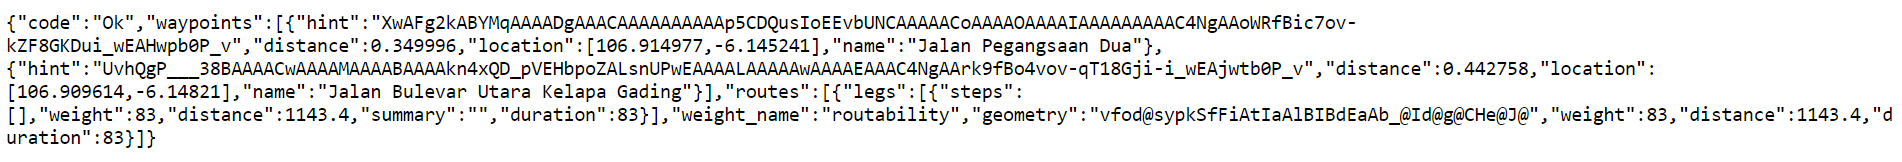

In [6]:
def reverseTuple(lstOfTuple): 
    return [tup[::-1] for tup in lstOfTuple]

# extract_route() parses the list of coordinates in the dictionary returned by get_route() 
# and returns the route geometry essential for outputting spatial features
def extract_route_osrm(routes_dict):
    route_coords_list= routes_dict['route']    
    listnew = reverseTuple(route_coords_list)    
    return(LineString(listnew))

def extract_duration_osrm(routes_dict):
    return(routes_dict['duration'])

def extract_distance_osrm(routes_dict):
    return(routes_dict['distance'])

In [7]:
df = pd.read_feather('/content/drive/MyDrive/processed_jkt.ftr')
df = df[df['trj_id'].isin(samples)]

In [39]:
# Applying the above methods to the dataframe to calculate and add attributes to the dataframe
def get_points(trj_id):
    #print(trj_id)
    temp = df[df.trj_id == trj_id]
    lo = temp.iloc[0]
    hi = temp.iloc[-1]
    return ([lo['rawlng'], lo['rawlat'], hi['rawlng'], hi['rawlat']])

In [40]:
start_time = time.time()
df_osrm = pd.DataFrame({'trj_id': samples})
df_osrm['routes'] = df_osrm.trj_id.progress_apply(lambda x: get_route_osrm(*get_points(x)))
df_osrm['geometry'] = df_osrm.progress_apply(lambda x: extract_route_osrm(x['routes']), axis=1)
df_osrm['osrm_dur'] = df_osrm.progress_apply(lambda x: extract_duration_osrm(x['routes']), axis=1)
df_osrm['osrm_dist'] = df_osrm.progress_apply(lambda x: extract_distance_osrm(x['routes']), axis=1)
print("Time taken: ", (time.time() - start_time), "seconds")
df_osrm

  0%|          | 0/897 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
100%|██████████| 897/897 [00:00<00:00, 57464.12it/s]

Time taken:  448.57612204551697 seconds


,trj_id,routes,geometry,osrm_dur,osrm_dist
0,67224,"{'route': [(-6.14041, 106.81426), (-6.13864, 1...","LINESTRING (106.81426 -6.14041, 106.81373 -6.1...",450.8,7994.5
1,66765,"{'route': [(-6.16999, 106.81102), (-6.17091, 1...","LINESTRING (106.81102 -6.16999, 106.81111 -6.1...",87.8,1068.3
2,54853,"{'route': [(-6.17941, 106.81706), (-6.17942, 1...","LINESTRING (106.81706 -6.17941, 106.81681 -6.1...",6.0,27.0
3,28910,"{'route': [(-6.25575, 106.86347), (-6.25575, 1...","LINESTRING (106.86347 -6.25575, 106.86351 -6.2...",53.5,770.5
4,67413,"{'route': [(-6.12432, 106.8714), (-6.12221, 10...","LINESTRING (106.8714 -6.12432, 106.86215 -6.12...",613.2,13962.8
...,...,...,...,...,...
892,41343,"{'route': [(-6.17404, 106.89217), (-6.17617, 1...","LINESTRING (106.89217 -6.17404, 106.89449 -6.1...",422.8,8432.2
893,46578,"{'route': [(-6.18097, 106.81731), (-6.18163, 1...","LINESTRING (106.81731 -6.18097, 106.81696 -6.1...",156.3,2103.6
894,68027,"{'route': [(-6.1867, 106.82318), (-6.19376, 10...","LINESTRING (106.82318 -6.1867, 106.82311 -6.19...",158.7,2810.2
895,66096,"{'route': [(-6.20055, 106.82328), (-6.20116, 1...","LINESTRING (106.82328 -6.20055, 106.82322 -6.2...",90.8,1538.4


In [9]:
# Create a geodataframe and pass the geometry column, created using extract_route() method, as the geometry information of the geodataframe
gdf_osrm = gpd.GeoDataFrame(df_osrm, geometry = df_osrm['geometry'])

# Export in whichever spatial formats you need to
gdf_osrm.to_file('jkt_OSRM.geojson', driver= 'GeoJSON')

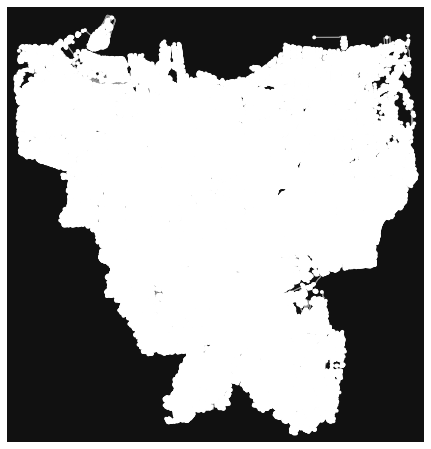

In [30]:
ox.config(log_console=True)
G = ox.graph_from_place('Jakarta, Indonesia')
fig, ax = ox.plot_graph(G)

In [41]:
def nodes_to_linestring_osmnx(path):
    coords_list = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in path ]
    #print(coords_list)
    if len(coords_list) == 1:
        coords_list *= 2
    
    line = LineString(coords_list)
    
    return(line)

def shortestpath_osmnx(o_lat, o_long, d_lat, d_long):
    nearestnode_origin, dist_o_to_onode = ox.nearest_nodes(G, o_lat, o_long, return_dist=True)
    nearestnode_dest, dist_d_to_dnode = ox.nearest_nodes(G, d_lat, d_long, return_dist=True)
    
    # Add up distance to nodes from both o and d ends. This is the distance that's not covered by the network
    dist_to_network = dist_o_to_onode + dist_d_to_dnode
    
    shortest_p = nx.shortest_path(G, nearestnode_origin, nearestnode_dest) 
    
    route = nodes_to_linestring_osmnx(shortest_p) #Method defined above
    
    # Calculating length of the route requires projection into UTM system. Using 
    inSpatialRef = osr.SpatialReference()
    inSpatialRef.ImportFromEPSG(4326)
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(32643)
    coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    #route.wkt returns wkt of the shapely object. This step was necessary as transformation can be applied 
    #only on an ogr object. Used EPSG 32643 as Bangalore is in 43N UTM grid zone.
    geom = ogr.CreateGeometryFromWkt(route.wkt)
   
    geom.Transform(coordTransform)
    length = geom.Length()
    
    #Total length to be covered is length along network between the nodes plus the distance from the O,D points to their nearest nodes
    total_length = length + dist_to_network
    #in metres
    
    return(route, total_length)

In [42]:
print(get_points('54853'))
shortestpath_osmnx(*get_points('54853'))

[106.817055, -6.1794133, 106.81681, -6.179422]


(<shapely.geometry.linestring.LineString at 0x7f10a1b65610>, 85.5656145777764)

In [43]:
start_time = time.time()

df_osmnx = pd.DataFrame({'trj_id': samples})
df_osmnx['osmnx_geometry'] = df_osmnx.trj_id.progress_apply(lambda x: shortestpath_osmnx(*get_points(x))[0])
df_osmnx['osmnx_length'] = df_osmnx.trj_id.progress_apply(lambda x: shortestpath_osmnx(*get_points(x))[1])

print("Time taken: ", (time.time() - start_time), "seconds")
df_osmnx
# Note that the lambda function returns a tuple. While applying the function, have add [0] and [1] to return only one of the two outputs. 
# There must be a nicer way to add both outputs in one go. This was more of a fluke try which worked. Alternatively, you could define two functions to return b

100%|██████████| 897/897 [1:04:14<00:00,  4.30s/it]

Time taken:  7725.628775596619 seconds


,trj_id,osmnx_geometry,osmnx_length
0,67224,"LINESTRING (106.8143337 -6.1406778, 106.814170...",8445.874560
1,66765,"LINESTRING (106.8110056 -6.1697945, 106.811055...",1299.788791
2,54853,"LINESTRING (106.8165453 -6.1794196, 106.816545...",85.565615
3,28910,"LINESTRING (106.863505 -6.2557462, 106.8635117...",253.062837
4,67413,"LINESTRING (106.8721254 -6.1239496, 106.872630...",380.214596
...,...,...,...
892,41343,"LINESTRING (106.8921354 -6.174341, 106.8915933...",8962.950452
893,46578,"LINESTRING (106.8173872 -6.1808338, 106.817170...",3781.024303
894,68027,"LINESTRING (106.8231688 -6.1869072, 106.823087...",3274.451970
895,66096,"LINESTRING (106.8233857 -6.2011095, 106.823374...",2684.401888


In [45]:
df_osmnx = df_osmnx.rename(columns = {'osmnx_geometry': 'geometry'})
gpdf_osmnx = gpd.GeoDataFrame(df_osmnx, geometry=df_osmnx['geometry'])
gpdf_osmnx.to_file('jkt_OSMNX.geojson', driver='GeoJSON')

In [21]:
gmaps = googlemaps.Client(key ='REDACTED')

In [24]:
def get_route_gmaps(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    origin = (pickup_lat,pickup_lon)
    dest = (dropoff_lat, dropoff_lon)
    
    directions_response = gmaps.directions(origin, dest, mode = "driving", departure_time = 1654254595) 
    # Always input a future time in epoch seconds. Can use an online converter E.g. https://www.epochconverter.com/
    return directions_response

# long, lat has to be passed in x,y format for shapely linestring object, hence 
# the tuples in the list returned by directions() function need to be inverted before constructing the linestring geometry

def extract_route_geom_gmaps(directions_response):
    line = directions_response[0]['overview_polyline']['points']
    route = polyline.decode(line)
    reverse_tup_list = reverseTuple(route)
    return(LineString(reverse_tup_list))
    
def extract_gdis_gmaps(directions_response):    
    gdis = directions_response[0]['legs'][0]['distance']['value']
    return gdis
    
def extract_gdur_gmaps(directions_response):
    gdur = directions_response[0]['legs'][0]['duration']['value']
    return gdur
    
def extract_gdur_traffic_gmaps(directions_response):
    gdur_traf = directions_response[0]['legs'][0]['duration_in_traffic']['value']
    return gdur_traf

In [28]:
start_time = time.time()

df_gmaps = pd.DataFrame({'trj_id': samples})
df_gmaps['responses'] = df_gmaps.trj_id.progress_apply(lambda x: get_route_gmaps(*get_points(x)))
df_gmaps['geometry'] = df_gmaps.progress_apply(lambda x: extract_route_geom_gmaps(x['responses']), axis = 1)
df_gmaps['gdis'] =  df_gmaps.progress_apply(lambda x: extract_gdis_gmaps(x['responses']), axis = 1)
df_gmaps['gdur'] =  df_gmaps.progress_apply(lambda x: extract_gdur_gmaps(x['responses']), axis = 1)
df_gmaps['gdur_traffic'] =  df_gmaps.progress_apply(lambda x: extract_gdur_traffic_gmaps(x['responses']), axis = 1)

print("Time taken: ", (time.time() - start_time), "seconds")
df_gmaps

 93%|█████████▎| 832/897 [00:00<00:00, 4123.48it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
100%|██████████| 897/897 [00:00<00:00, 51936.65it/s]


Time taken:  56.78992557525635 seconds


,trj_id,responses,geometry,gdis,gdur,gdur_traffic
0,67224,"[{'bounds': {'northeast': {'lat': -6.1386375, ...","LINESTRING (106.81424 -6.14042, 106.81396 -6.1...",7989,1055,1763
1,66765,"[{'bounds': {'northeast': {'lat': -6.1699858, ...","LINESTRING (106.81102 -6.16999, 106.8111 -6.17...",1069,172,196
2,54853,[{'bounds': {'northeast': {'lat': -6.177651000...,"LINESTRING (106.81706 -6.17943, 106.81803 -6.1...",1683,373,379
3,28910,"[{'bounds': {'northeast': {'lat': -6.2531585, ...","LINESTRING (106.86349 -6.25572, 106.86352 -6.2...",764,110,243
4,67413,"[{'bounds': {'northeast': {'lat': -6.1167012, ...","LINESTRING (106.8714 -6.1243, 106.86738 -6.123...",14528,1007,1787
...,...,...,...,...,...,...
892,41343,[{'bounds': {'northeast': {'lat': -6.174059199...,"LINESTRING (106.89216 -6.17406, 106.89259 -6.1...",7285,918,1102
893,46578,"[{'bounds': {'northeast': {'lat': -6.1809704, ...","LINESTRING (106.81731 -6.18097, 106.81702 -6.1...",2018,309,466
894,68027,[{'bounds': {'northeast': {'lat': -6.186700800...,"LINESTRING (106.82319 -6.1867, 106.82315 -6.18...",2813,297,614
895,66096,"[{'bounds': {'northeast': {'lat': -6.2005483, ...","LINESTRING (106.82328 -6.20055, 106.82322 -6.2...",1538,139,365


In [29]:
df_gmaps.to_csv('gmaps_routes_responses.csv')
df_gmaps = df_gmaps.drop(columns = ['responses'])
gdf_gmaps = gpd.GeoDataFrame(df_gmaps, geometry = df_gmaps['geometry'])
gdf_gmaps.to_file('jkt_GMAPS.geojson', driver= 'GeoJSON')